In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Exercises

<div class="alert alert-block alert-info">

**1. Euler-Cromer**

A simple change to the first-order Euler method is to update the velocity first and then use the new velocity to evaluate the position:

$${\bf v}^{n+1} = {\bf v}^n + \tau \, {\bf a}({\bf r}^{n})$$

$${\bf r}^{n+1} = {\bf r}^n + \tau \, {\bf v}^{n+1}$$

    
This is called the *Euler-Cromer* method. 
In this sense, we are treating the position update implicitly.

Integrate the orbit problem with Euler-Cromer and compare to the standard Euler method.  Why do you think the solutions look so different if they are both first-order?
</div>

To make things simpler, we split the RHS routine into 2, one producing the update to position and one for velocity.

In [5]:
G = 4*np.pi**2
M_sun = 1.0

def rhs_r(t, Y):
    
    # unpack just to make things easier to read
    x, y, vx, vy = Y
    
    xdot = vx
    ydot = vy

    return np.array([xdot, ydot])

def rhs_v(t, Y):

    # unpack just to make things easier to read
    x, y, vx, vy = Y

    r = np.sqrt(x * x + y * y)
    
    vxdot = -G * M_sun * x / r**3
    vydot = -G * M_sun * y / r**3
    
    return np.array([vxdot, vydot])

In [6]:
class OrbitHistory:
    """store the time history of the orbit solution"""
    
    def __init__(self):
        self.t = []
        self.x = []
        self.y = []
        self.vx = []
        self.vy = []
        
    def store_current_solution(self, t, Y):
        self.t.append(t)
        self.x.append(Y[0])
        self.y.append(Y[1])
        self.vx.append(Y[2])
        self.vy.append(Y[3])
        
    def plot(self, ax=None, label=None):
        """make a plot of the solution.  If ax is None we setup a figure
        and make the entire plot returning the figure object, otherwise, we
        just append the plot to a current axis"""

        fig = None
        
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(111)

            # draw the Sun
            ax.scatter([0], [0], marker=(20,1), color="y", s=250)

        # draw the orbit
        ax.plot(self.x, self.y, label=label)

        if fig is not None:
            ax.set_aspect("equal")
            ax.set_xlabel("x [AU]")
            ax.set_ylabel("y [AU]")
            
            return fig, ax

In [7]:
def initial_conditions():
    x0 = 0
    y0 = 1
    vx0 = -np.sqrt(G*M_sun/y0)
    vy0 = 0

    return np.array([x0, y0, vx0, vy0])

In [8]:
def euler_orbit(Y0, tau, T):
    
    # we'll return an orbit history object
    o = OrbitHistory()
    
    # storage for the new solution
    Y = Y0.copy()
    
    # initialize time
    t = 0
    
    # store the initial conditions
    o.store_current_solution(t, Y0)
    
    # main timestep loop
    while t < T:
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        Rdot = rhs_r(t, Y)
        Vdot = rhs_v(t, Y)
        
        Y[0] += tau * Rdot[0]
        Y[1] += tau * Rdot[1]

        Y[2] += tau * Vdot[0]
        Y[3] += tau * Vdot[1]

        t += tau
        
        # store the state
        o.store_current_solution(t, Y)
        
    return o
        

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x [AU]', ylabel='y [AU]'>)

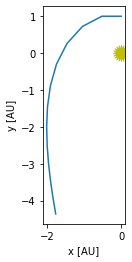

In [9]:
Y0 = initial_conditions()
tau = 1.0/12.0

orbit = euler_orbit(Y0, tau, 1)

orbit.plot()

In [11]:
def euler_cromer_orbit(Y0, tau, T):
    
    # we'll return an orbit history object
    o = OrbitHistory()
    
    # storage for the new solution
    Y = Y0.copy()
    
    # initialize time
    t = 0
    
    # store the initial conditions
    o.store_current_solution(t, Y0)
    
    # main timestep loop
    while t < T:
        
        # make sure that the last step does not take us past T
        if t + tau > T:
            tau = T - t

        # get the RHS
        Vdot = rhs_v(t, Y)
                
        Y[2] += tau * Vdot[0]
        Y[3] += tau * Vdot[1]
        
        Rdot = rhs_r(t, Y)
        
        Y[0] += tau * Rdot[0]
        Y[1] += tau * Rdot[1]

        t += tau
        
        # store the state
        o.store_current_solution(t, Y)
        
    return o
        

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x [AU]', ylabel='y [AU]'>)

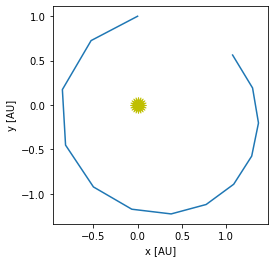

In [12]:
tau = 1.0/12.0

orbit = euler_cromer_orbit(Y0, tau, 1)
orbit.plot()

What's going on here?  Clearly the orbit looks a lot better for Euler-Cromer than just Euler.  

The reason is that Euler-Cromer actually conserves a discrete form of angular momentum, while standard Euler does not.  Euler-Cromer is an example of a [symplectic integrator](https://en.wikipedia.org/wiki/Symplectic_integrator).

<div class="alert alert-block alert-info">

**2. Energy conservation**

We can define the total energy / mass of our orbit system as:
    
$$\mathcal{E} = \frac{1}{2} |{\bf v}|^2 - \frac{GM_\star}{r}$$
    
since the mass of our planet does not change, this is conserved.  Plot $\mathcal{E}$ vs. time for the orbit for the different methods we looked at (including Euler-Cromer, from above).  How well do they conserve energy?
    
</div>

<div class="alert alert-block alert-info">

**3. Chaos**

The equations of motion for a double pendulum consisting of two equal length rigid rods are:
    
$$\dot{\theta}_1 = \frac{6}{I} \frac{2 {p_\theta}_1 - 3 \cos(\theta_1 - \theta_2) {p_\theta}_2}{16 - 9 \cos^2 (\theta_1 - \theta_2)}$$
    
$$\dot{\theta}_2 = \frac{6}{I} \frac{2 {p_\theta}_2 - 3 \cos(\theta_1 - \theta_2) {p_\theta}_1}{16 - 9 \cos^2 (\theta_1 - \theta_2)}$$
    
$${\dot{p}_\theta}_1 = -\frac{1}{2} I \left (\dot{\theta}_1\dot{\theta}_2 \sin(\theta_1 - \theta_2) + 3 \frac{g}{l} \sin \theta_1 \right )$$
    
$${\dot{p}_\theta}_2 = -\frac{1}{2} I \left (-\dot{\theta}_1\dot{\theta}_2 \sin(\theta_1 - \theta_2) +  \frac{g}{l} \sin \theta_2 \right )$$
    

where $I = m l^2$ is the moment of inertia, $\theta_1$ and $\theta_2$ are
the angles of the two rods with respect to the vertical and ${p_\theta}_1$
    and ${p_\theta}_2$ are generalized momenta.  See the [wikipedia page on double pendulum](https://en.wikipedia.org/wiki/Double_pendulum) for a derivation.

Write a routine to integrate this system using RK4, given initial angles
$\theta_1$ and $\theta_2$ (take the initial momenta to be 0).
    
    
A double pendulum system is nonlinear and can exhibit chaotic behavior&mdash;the solution at some time in the future depends sensitively on the initial conditions.  Make a plot of the solution you get ($\theta_1$ and $\theta_2$ vs. time) with two very closely spaced sets of initial conditions.  What happens to the evolution?
    

    
    
</div>